
# Single-Cell RNA-seq Analysis with scVI (Adapted for TSV File)
This notebook demonstrates a single-cell RNA-seq analysis workflow using scVI on the provided .tsv file.

## Import Required Libraries


In [2]:

# Import necessary libraries
%matplotlib inline
import os
import scanpy as sc
import scvi
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Seed for reproducibility
scvi.settings.seed = 0


d:\python3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 0


In [22]:

# Define the path to the data file
data_path = "./data_dir/data_file/GSM3576396_C9_R_cell-gene_UMI_table.tsv"

# Load the data file as a DataFrame and convert to AnnData
df = pd.read_csv(data_path, sep='\t')
# Set the cell ID as the index and separate genes
df.set_index('cell_id', inplace=True)
adata = sc.AnnData(df)

# Basic information on the dataset
print(adata)


AnnData object with n_obs × n_vars = 321 × 10105


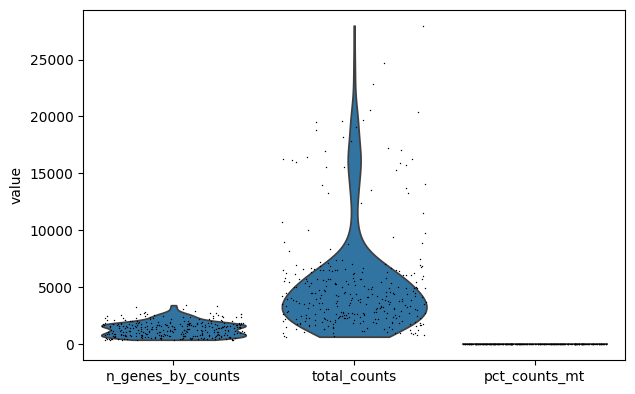

In [23]:

# Quality Control
# Identify mitochondrial genes based on their names (assuming 'MT-' prefix for mitochondrial genes)
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# Calculate quality control metrics, including mitochondrial content
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

# Violin plot to visualize quality metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4)

# Filter out low-quality cells and genes
adata = adata[adata.obs.n_genes_by_counts < 5000, :]
adata = adata[:, adata.var.n_cells_by_counts > 3]


In [24]:

# Normalize and log-transform the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

C:\Users\silviachen\AppData\Roaming\Python\Python311\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Top 10 highly variable genes: Index(['CST3', 'IGKV1.27', 'IGHV3.11', 'IGHV3.33', 'IGHG3', 'IGHV4.4',
       'IGKV1D.39', 'IGLV1.47', 'TRBV12.3', 'TRBV7.2'],
      dtype='object')


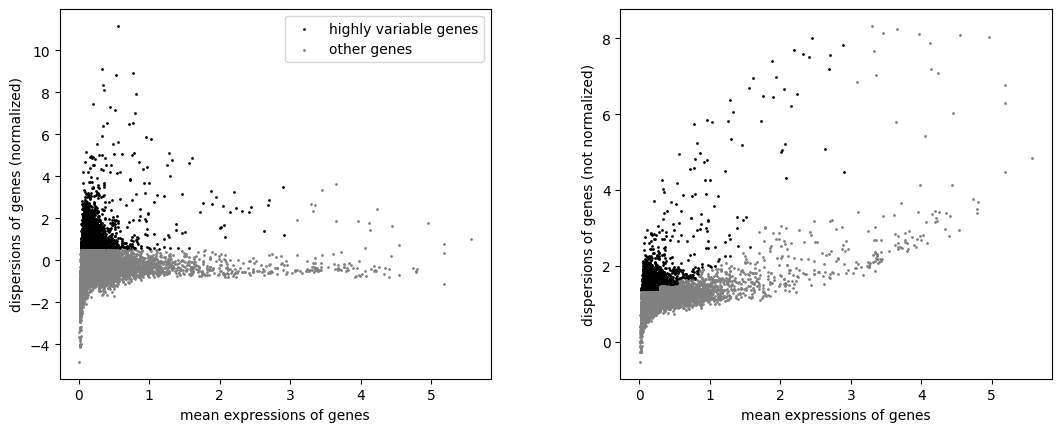

In [25]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Display the top 10 highly variable genes
top10 = adata.var[adata.var['highly_variable']].sort_values(by='dispersions_norm', ascending=False).index[:10]
print("Top 10 highly variable genes:", top10)

# Optional: Plot variable features
sc.pl.highly_variable_genes(adata)

In [26]:
hvg_adata = adata[:, adata.var['highly_variable']].copy()

In [34]:
hvg_adata

AnnData object with n_obs × n_vars = 321 × 2249
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [27]:
hvg_adata.write("hvg_only_adata.h5ad")  

In [28]:
adata = sc.read_h5ad('hvg_only_adata.h5ad')

In [29]:


# Set up scVI model for batch effect correction and dimensionality reduction
# Assuming no batch information in adata.obs, so batch_key=None
scvi.model.SCVI.setup_anndata(adata, batch_key=None)
vae = scvi.model.SCVI(adata)
vae.train(max_epochs=30)  # Train the scVI model

# Use scVI latent space to generate corrected representation
adata.obsm["X_scVI"] = vae.get_latent_representation()
print("Latent representation stored in adata.obsm['X_scVI']")


d:\python3.11\Lib\site-packages\scvi\data\fields\_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\python3.11\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
d:\python3.11\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 2/30:   3%|▎         | 1/30 [00:00<00:03,  8.40it/s, v_num=1, train_loss_step=854, train_loss_epoch=824]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 3/30:   7%|▋         | 2/30 [00:00<00:03,  8.40it/s, v_num=1, train_loss_step=828, train_loss_epoch=805]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 4/30:  13%|█▎        | 4/30 [00:00<00:02,  9.38it/s, v_num=1, train_loss_step=794, train_loss_epoch=778]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 6/30:  17%|█▋        | 5/30 [00:00<00:02, 10.45it/s, v_num=1, train_loss_step=724, train_loss_epoch=766]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 7/30:  20%|██        | 6/30 [00:00<00:02, 10.45it/s, v_num=1, train_loss_step=809, train_loss_epoch=758]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 9/30:  27%|██▋       | 8/30 [00:00<00:02, 10.93it/s, v_num=1, train_loss_step=729, train_loss_epoch=742]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 10/30:  30%|███       | 9/30 [00:00<00:01, 11.46it/s, v_num=1, train_loss_step=713, train_loss_epoch=735]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 12/30:  37%|███▋      | 11/30 [00:00<00:01, 11.52it/s, v_num=1, train_loss_step=761, train_loss_epoch=723]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 13/30:  40%|████      | 12/30 [00:01<00:01, 11.52it/s, v_num=1, train_loss_step=719, train_loss_epoch=719]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 15/30:  47%|████▋     | 14/30 [00:01<00:01, 11.78it/s, v_num=1, train_loss_step=730, train_loss_epoch=709]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 16/30:  50%|█████     | 15/30 [00:01<00:01, 11.86it/s, v_num=1, train_loss_step=736, train_loss_epoch=706]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 18/30:  57%|█████▋    | 17/30 [00:01<00:01, 11.72it/s, v_num=1, train_loss_step=721, train_loss_epoch=699]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 21/30:  67%|██████▋   | 20/30 [00:01<00:00, 11.61it/s, v_num=1, train_loss_step=663, train_loss_epoch=690]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 23/30:  77%|███████▋  | 23/30 [00:02<00:00, 11.29it/s, v_num=1, train_loss_step=709, train_loss_epoch=685]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 26/30:  83%|████████▎ | 25/30 [00:02<00:00, 11.51it/s, v_num=1, train_loss_step=707, train_loss_epoch=678]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 29/30:  93%|█████████▎| 28/30 [00:02<00:00, 11.55it/s, v_num=1, train_loss_step=691, train_loss_epoch=672]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 30/30: 100%|██████████| 30/30 [00:02<00:00, 11.68it/s, v_num=1, train_loss_step=678, train_loss_epoch=669]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 30/30: 100%|██████████| 30/30 [00:02<00:00, 11.42it/s, v_num=1, train_loss_step=678, train_loss_epoch=669]
Latent representation stored in adata.obsm['X_scVI']


In [30]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

# Filter to keep only HVGs if desired
adata = adata[:, adata.var.highly_variable]

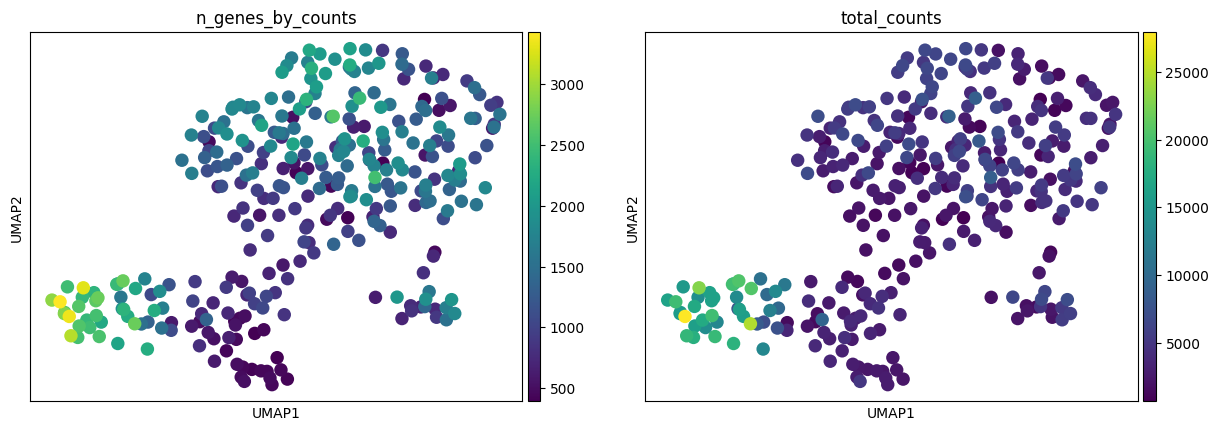

In [31]:

# Use the scVI representation to compute neighbors and UMAP
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=20)

# Compute UMAP for visualization
sc.tl.umap(adata)
sc.pl.umap(adata, color=["n_genes_by_counts", "total_counts"])


C:\Users\silviachen\AppData\Local\Temp\ipykernel_6060\857446468.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


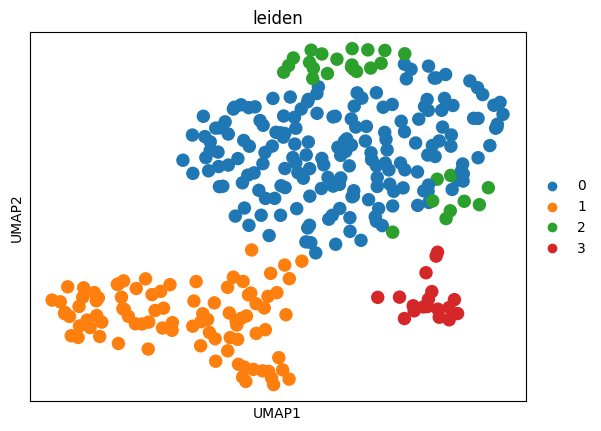

In [32]:

# Perform clustering using the Leiden algorithm on the scVI latent space
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color=["leiden"])


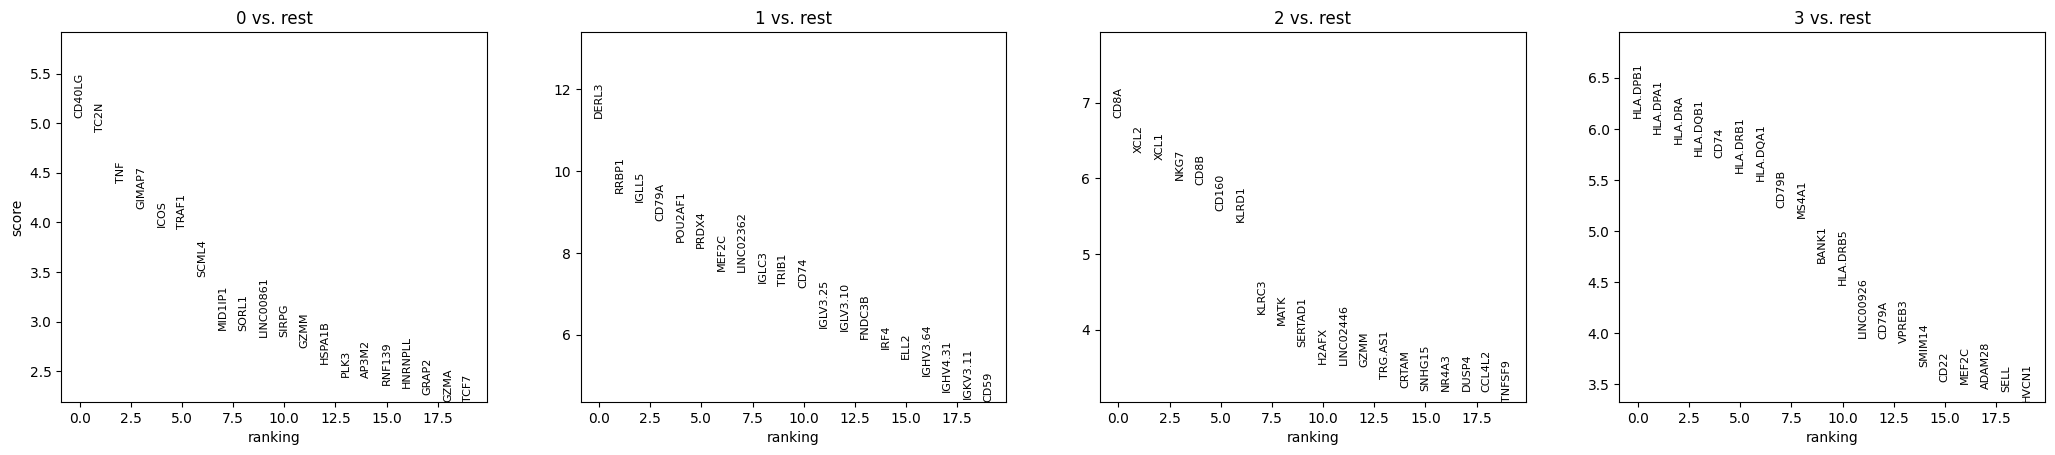

In [33]:

# Differential expression analysis to identify marker genes for each cluster
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)
